In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
from skimage import io

In [2]:
# Understanding data - csv
# image_path = '/media/nicolas/Lenovo/Projects/UnderstandingAmazon/data'

#https://www.kaggle.com/competitions/planet-understanding-the-amazon-from-space

#inspiration from
#https://www.kaggle.com/code/robinkraft/getting-started-with-the-data-now-with-docs

In [3]:
train_data = pd.read_csv(os.path.join('data','train_v2.csv'))

In [4]:
train_data.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [5]:
#so many individual classes
class_num = train_data['tags'].value_counts()
class_num

clear primary                                               13636
partly_cloudy primary                                        3630
cloudy                                                       2089
clear primary water                                          1850
agriculture clear primary road                               1680
                                                            ...  
agriculture clear cultivation cultivation road                  1
artisinal_mine bare_ground partly_cloudy primary road           1
agriculture clear conventional_mine primary road                1
clear conventional_mine habitation road                         1
agriculture partly_cloudy primary road conventional_mine        1
Name: tags, Length: 449, dtype: int64

In [6]:
#seems like some tags have duplicated information 
# eg -> agriculture clear cultivation cultivation road has 'cultivation' repetated.
# lets clean that out
train_data['tags_no_dups'] = train_data['tags'].str.split().apply(lambda x:' '.join(set(x)))

In [7]:
#count how many individual classes are in the dataset
from collections import Counter
counter = Counter()
for pic in train_data['tags'].str.split():
    counter.update(pic)

In [9]:
class_num = train_data['tags_no_dups'].value_counts()
class_num

primary clear                                                                    13636
primary partly_cloudy                                                             3630
cloudy                                                                            2089
primary water clear                                                               1850
road primary clear agriculture                                                    1680
                                                                                 ...  
cultivation primary selective_logging slash_burn water road clear agriculture        1
water artisinal_mine clear road                                                      1
primary artisinal_mine bare_ground partly_cloudy road                                1
habitation clear conventional_mine road                                              1
primary conventional_mine road partly_cloudy agriculture                             1
Name: tags_no_dups, Length: 412, dtype: int

In [10]:
individual_label = pd.DataFrame(counter.values(),counter.keys()).sort_values(by =0 , ascending = False)
individual_label.rename({0:'count'},axis = 1,inplace = True)
individual_label = individual_label.reset_index()

In [11]:
individual_label.rename({'index':'label'},axis = 1,inplace = True)

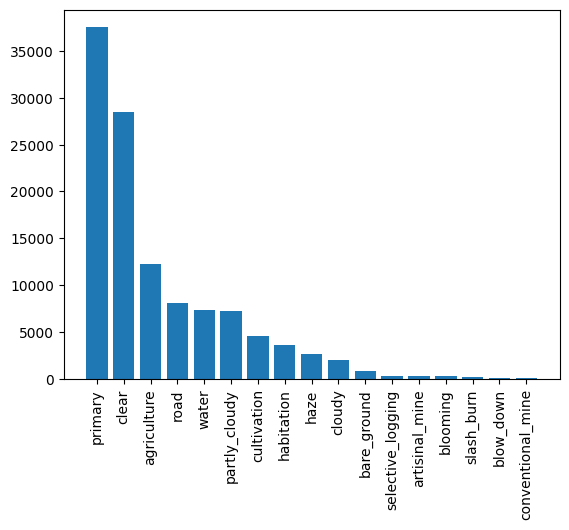

In [12]:
plt.bar(individual_label['label'],individual_label['count'])
plt.xticks(rotation = 90)
plt.show()

In [13]:
individual_label

,label,count
0,primary,37513
1,clear,28431
2,agriculture,12315
3,road,8071
4,water,7411
5,partly_cloudy,7261
6,cultivation,4547
7,habitation,3660
8,haze,2697
9,cloudy,2089


In [13]:
#Chips that are labeled as cloudy should have no other labels, but there may be labeling errors
#correct

In [14]:
train_data[~(train_data['tags_no_dups'].str.contains('partly_cloudy'))&
            (train_data['tags_no_dups'].str.contains('cloudy'))&
            (train_data['tags_no_dups'].str.split().apply(lambda x:len(x)) != 1)]


,image_name,tags,tags_no_dups


In [15]:
#tags per image one hot
for tag in individual_label['label']:
    train_data[tag] = train_data['tags_no_dups'].apply(lambda x:1 if tag in x.split() else 0)

In [16]:
train_data.head()

,image_name,tags,tags_no_dups,primary,clear,agriculture,road,water,partly_cloudy,cultivation,habitation,haze,cloudy,bare_ground,selective_logging,artisinal_mine,blooming,slash_burn,blow_down,conventional_mine
0,train_0,haze primary,haze primary,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,train_1,agriculture clear primary water,primary water clear agriculture,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,train_2,clear primary,primary clear,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,train_3,clear primary,primary clear,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,train_4,agriculture clear habitation primary road,clear primary road habitation agriculture,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0


In [17]:
weather_labels = ['haze','partly_cloudy','clear','cloudy']

In [18]:
train_data[weather_labels].sum()

haze              2697
partly_cloudy     7261
clear            28431
cloudy            2089
dtype: int64

In [19]:
#from notebook
def heatmap_matrix(labels):
    numeric_df = train_data[individual_label['label']][labels]
    matrix = numeric_df.T.dot(numeric_df)
    sns.heatmap(matrix,cmap='Blues')
    return matrix

,primary,clear,agriculture,road,water,partly_cloudy,cultivation,habitation,haze,cloudy,bare_ground,selective_logging,artisinal_mine,blooming,slash_burn,blow_down,conventional_mine
primary,37513,27668,11972,7728,7001,7175,4455,3469,2670,0,683,340,324,332,209,98,94
clear,27668,28431,9150,6295,5502,0,3527,3090,0,0,747,308,307,311,173,85,70
agriculture,11972,9150,12315,6034,2712,2493,3377,2737,672,0,225,65,38,32,119,22,24
road,7728,6295,6034,8071,2125,1382,1294,2786,394,0,323,151,110,10,36,2,59
water,7001,5502,2712,2125,7411,1295,868,915,613,0,206,49,299,16,24,3,26
partly_cloudy,7175,0,2493,1382,1295,7261,748,441,0,0,74,27,27,17,33,13,28
cultivation,4455,3527,3377,1294,868,748,4477,895,202,0,89,58,18,35,126,8,4
habitation,3469,3090,2737,2786,915,441,895,3660,129,0,163,13,29,4,41,3,36
haze,2670,0,672,394,613,0,202,129,2697,0,41,5,5,4,3,0,2
cloudy,0,0,0,0,0,0,0,0,0,2089,0,0,0,0,0,0,0


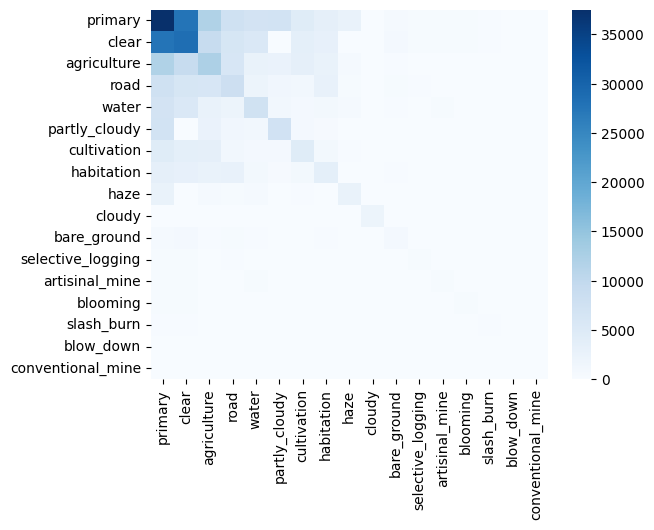

In [20]:
heatmap_matrix(individual_label['label'])

In [21]:
rare_individual = individual_label[individual_label['count'] < 2000]

In [22]:
rare_individual

,label,count
10,bare_ground,862
11,selective_logging,340
12,artisinal_mine,339
13,blooming,332
14,slash_burn,209
15,blow_down,101
16,conventional_mine,100


In [23]:
#Images

In [24]:
#select images to display

In [25]:
top_10_classes = class_num[:10]
last_10_classes = class_num[-10:]

In [26]:
top_10_classes.index

Index(['primary clear', 'primary partly_cloudy', 'cloudy',
       'primary water clear', 'road primary clear agriculture',
       'primary clear agriculture', 'haze primary',
       'primary cultivation clear agriculture',
       'clear primary road habitation agriculture',
       'primary water clear agriculture'],
      dtype='object')

In [27]:
#first mount disk
image_path = '/media/nicolas/Lenovo/Projects/UnderstandingAmazon/data'
image_jpg_list = os.path.join(image_path,'train-jpg')
image_tiff_list = os.path.join(image_path,'train-tif-v2')

In [28]:
def random_sample(labels,ext):
    images = []
    if ext == '.jpg':
        dirname = image_jpg_list
    else:
        dirname = image_tiff_list
    
    for image in labels.index:
        image_name = train_data[train_data['tags_no_dups']== image].sample(1,random_state=1080)['image_name'].iloc[0] + ext
        img = io.imread(os.path.join(dirname,image_name))
        images.append([image_name,image,img])
    return images

In [29]:
#from notebook in kaggle
def plot_rgbn_histo(image):
    bgr_image = image[:,:,:3]
    rgb_image = image[:, :, [2,1,0]]
    
    b, g, r = image[:, :, 0], image[:, :, 1], image[:, :, 2]
    for slice_, name, color in ((r,'r', 'red'),(g,'g', 'green'),(b,'b', 'blue')):
        plt.hist(slice_.ravel(), bins=100, 
                 range=[0,rgb_image.max()], 
                 label=name, color=color, histtype='step')
    plt.legend()

In [30]:
images_jpg = random_sample(top_10_classes,'.jpg')
images_tif = random_sample(top_10_classes,'.tif')

In [31]:
images_jpg_last = random_sample(last_10_classes,'.jpg')

In [32]:
images_jpg[0][1],images_tif[0][1]

('primary clear', 'primary clear')

In [33]:
sample_image_jpg = images_jpg[0][2]
sample_image_tif = images_tif[0][2]


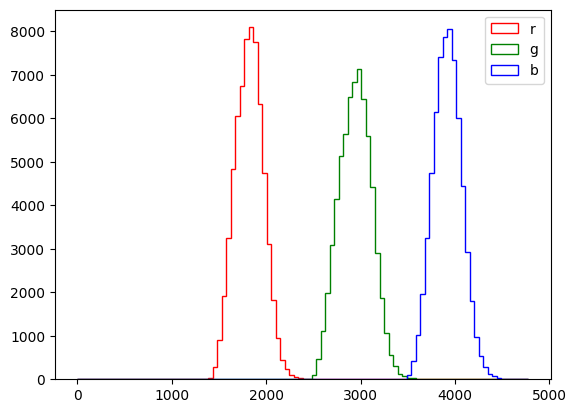

In [34]:
plot_rgbn_histo(sample_image_tif)

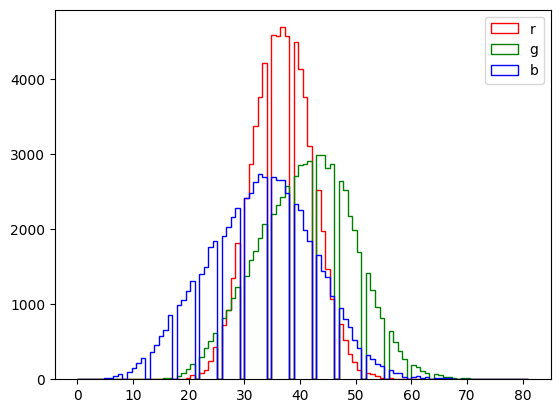

In [35]:
plot_rgbn_histo(sample_image_jpg)

In [36]:
def plot_images(images):
    fig = plt.figure(figsize=(20, 20))
    for i,img in enumerate(images):
        ax = fig.add_subplot(2, 5, i+1)
        ax.set_title(img[1],fontsize = 8)
        fig.set_figheight(8)
        fig.set_figwidth(28)
        plt.imshow(img[2])
    plt.show()

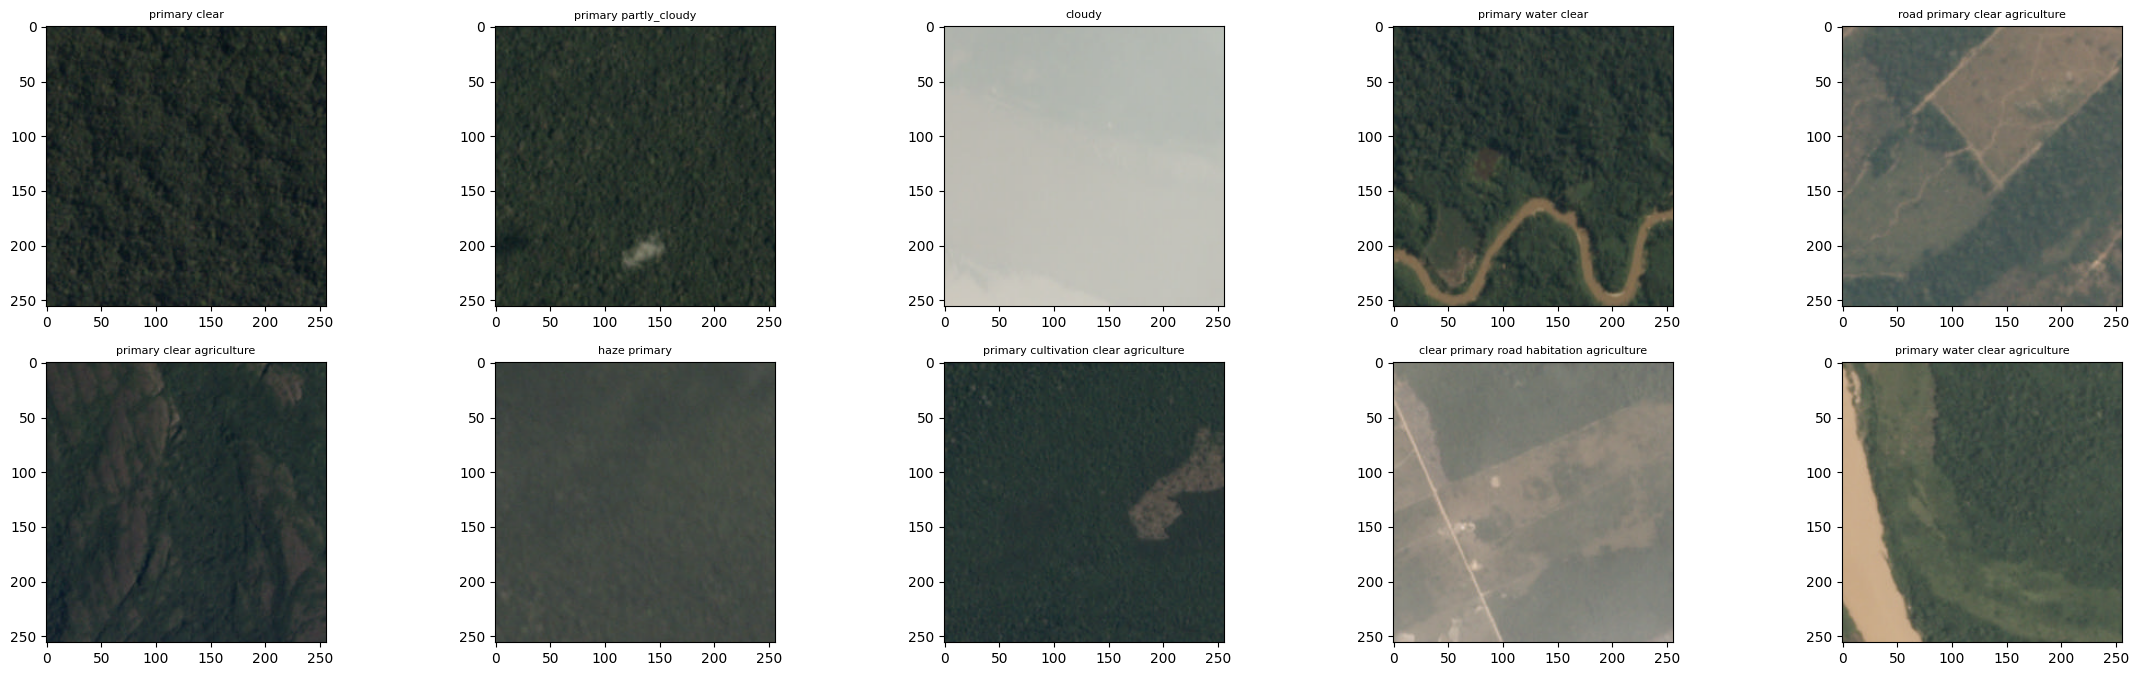

In [37]:
plot_images(images_jpg)

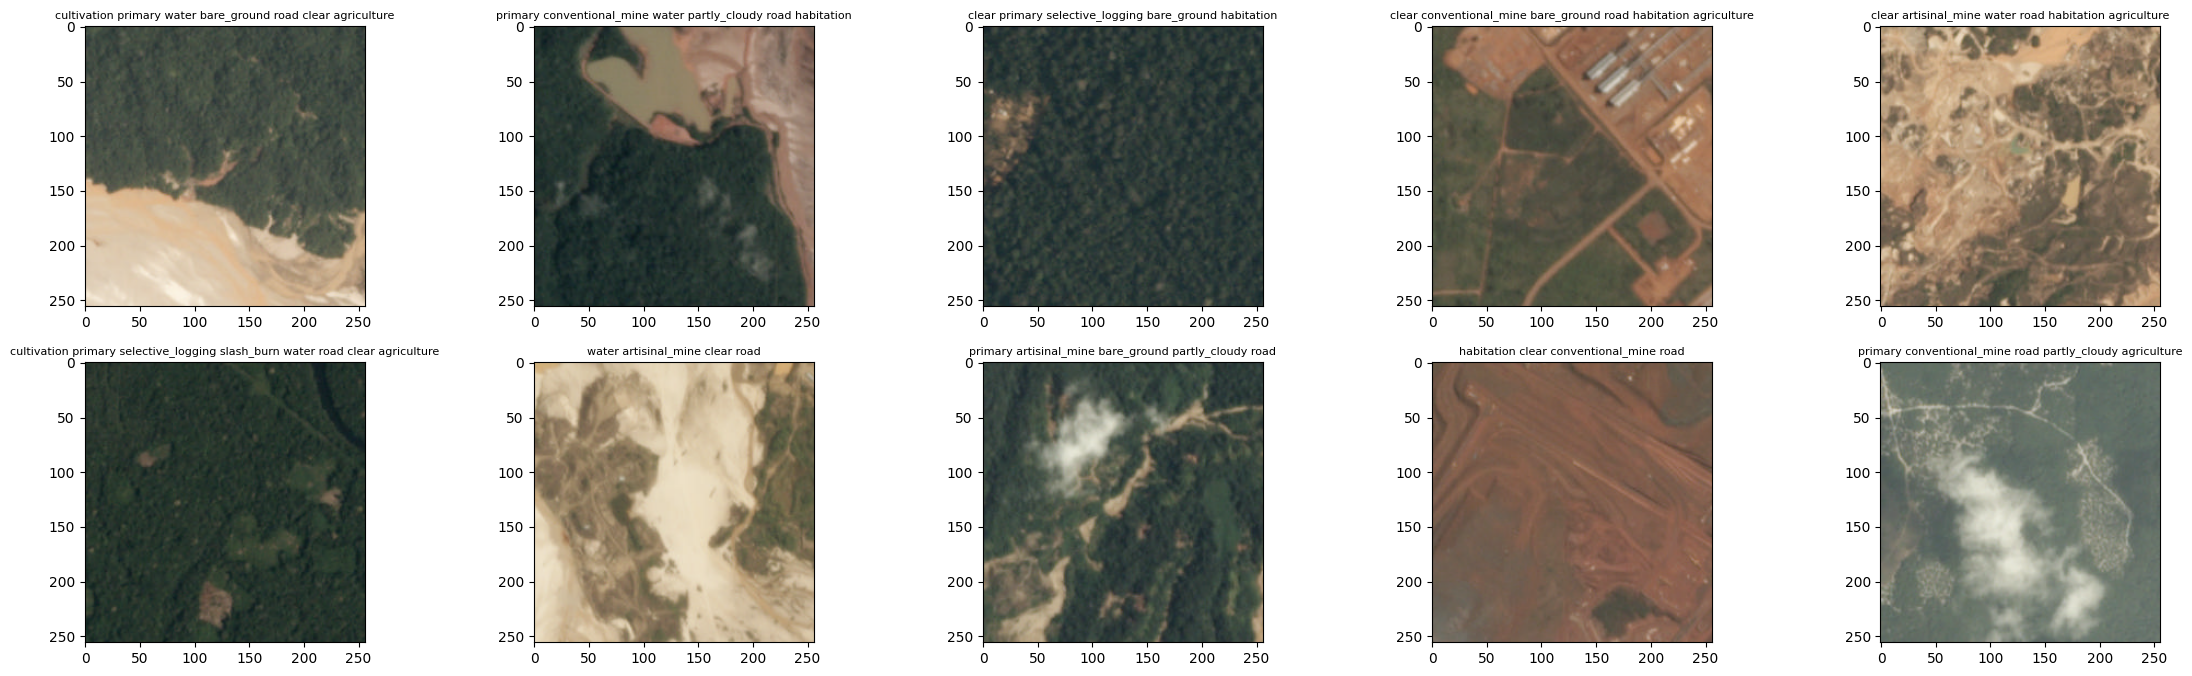

In [38]:
plot_images(images_jpg_last)